In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Brain Tumor Images
folder_path = 'Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

# Normal Brain Images
folder_path = 'Brain Tumor Data Set/Healthy'
image_files_normal = [file for file in os.listdir(folder_path)]

### Visualizing the data

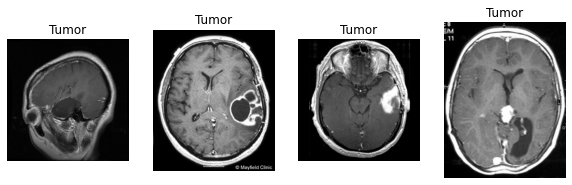

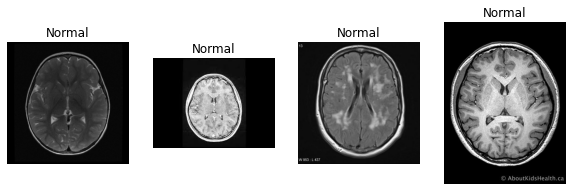

In [3]:
# Displaying Brain Tumor Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Brain Tumor/' + image_files_tumor[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Tumor')
plt.show()

# Displaying Normal Brain Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Healthy/' + image_files_normal[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Normal')
    
plt.show()

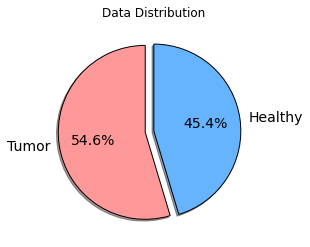

In [4]:
# visualizing the data distribution
data = {'Tumor': len(image_files_tumor), 'Healthy': len(image_files_normal)}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots()
ax.pie(values, labels=names, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0), shadow=True, textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black'})
ax.set_title('Data Distribution')
plt.show()

In [32]:
url_tumor = 'Brain Tumor Data Set/Brain Tumor/'
url_healthy = 'Brain Tumor Data Set/Healthy/'

# Merging the data
data = []
data_gray = []
for file in image_files_tumor:
    # save the image and the label (1 for tumor)
    img = cv2.imread(url_tumor + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 1]) # 1 for tumor
    data_gray.append([grayscale_image, 1])
  
for file in image_files_normal:
    img = cv2.imread(url_healthy + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 0]) # 0 for normal
    data_gray.append([grayscale_image, 0])
    
# Creating a DataFrame
df = pd.DataFrame(data, columns=['image', 'label'])

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)


In [34]:
df_gray =  pd.DataFrame(data_gray, columns=['image', 'label'])
df_gray = df_gray.sample(frac=1).reset_index(drop=True)

In [35]:
df_gray.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 5,...",0
2,"[[13, 19, 23, 20, 16, 16, 16, 13, 12, 13, 16, ...",1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [14]:
df.head(10)

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[191, 191, 191], [9, 9, 9], [32, 32, 32], [3...",0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
8,"[[[2, 2, 2], [1, 1, 1], [3, 3, 3], [4, 4, 4], ...",0
9,"[[[1, 1, 1], [3, 3, 3], [2, 2, 2], [3, 3, 3], ...",1


In [7]:
# We have a meta data file that contains more information about the images

# Load the meta data
meta_data = pd.read_csv('metadata.csv', index_col=0)
meta_data.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


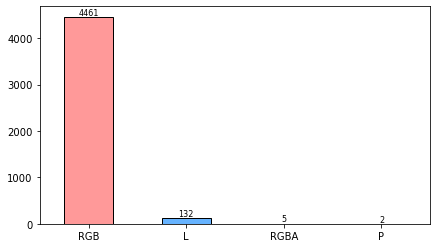

In [8]:
meta_data['mode'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff', '#ff55','#66b344'], rot=0, figsize=(7, 4), edgecolor='black')
for i, v in enumerate(meta_data['mode'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()

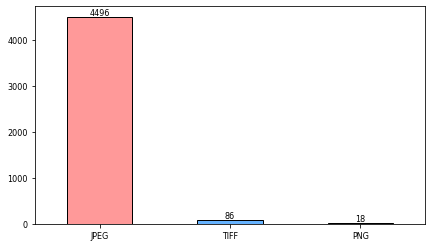

In [9]:
meta_data['format'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99'], figsize=(7, 4), edgecolor='black', fontsize=8, rot=0)
for i, v in enumerate(meta_data['format'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)


In [30]:
df.count()

image    4600
label    4600
dtype: int64

#### Step 1: Filtering Images by Color Format

In this initial phase of our process, we focus exclusively on utilizing images that are in **RGB format**. 

In [37]:
# Split the data
X = df['image'].values
y = df['label'].values

In [38]:
# Normalizing the data
X = X/ 255

In [39]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Flatten the image data
X_train_flat = np.array([x.flatten() for x in X_train])
X_val_flat = np.array([x.flatten() for x in X_val])

# Create the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model.fit(X_train_flat, y_train)

# Make predictions
y_pred = model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Initial Accuracy: {accuracy:.4f}')

# Perform hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 300)
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, scoring='accuracy', cv=3, n_jobs=-1, random_state=42, verbose=True)
random_search.fit(X_train_flat, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best accuracy: {random_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy with best model: {accuracy:.4f}')


Initial Accuracy: 0.9633
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint


### Random Forest Model

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform hyperparameter tuning with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_split': randint(2, 11)
}

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=5, scoring='accuracy', cv=3, random_state=42, n_jobs=-1,verbose=True)
random_search_rf.fit(X_train_f, y_train)

# Print the best parameters and the best score
print(f"Random Forest Best parameters: {random_search_rf.best_params_}")
print(f"Random Forest Best accuracy: {random_search_rf.best_score_:.4f}")

# Use the best model to make predictions
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_val)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy with best model: {accuracy_rf:.4f}')
